In [2]:
# !pip install torch torchvision --index-url https://download.pytorch.org/whl/cu126

In [3]:
from tokenizers import pre_tokenizers, trainers, decoders, models, normalizers, Tokenizer
import json
import random
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
import string
import re

In [4]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
if torch.cuda.is_available():
    print("Number of GPUs:", torch.cuda.device_count())
    print("Current GPU:", torch.cuda.current_device())
    print("GPU name:", torch.cuda.get_device_name(0))

PyTorch version: 2.7.1+cu126
CUDA available: True
CUDA version: 12.6
Number of GPUs: 1
Current GPU: 0
GPU name: NVIDIA GeForce GTX 1650 SUPER


In [5]:
train_dataset = []
val_dataset = []
test_dataset = []

def clean_text_en(text):
    # return re.sub(r'[^a-zA-Z0-9 ]', '', text.lower())
    return text

def clean_text_zt(text):
    # return re.sub(r'[^0-9■□▢▣▤▥▦▧▨▩▪▫▬▭▮▯▰▱▲△▴▵▶▷▸▹►▻▼▽▾▿◀◁◂◃◄◅◆◇◈◉◊○◌◍◎●◐◑◒◓◔◕◖◗◘◙◚◛◜◝◞◟◠◡◢◣◤◥◦◧◨◩◪◫◬◭◮◯◰◱◲◳ ]', '', text.lower())
    return text

with open(r"train", "r", encoding="utf8") as f:
    for line in f:
        train_dataset.append(json.loads(line))
        train_dataset[-1]["dst"] = clean_text_en(train_dataset[-1]["dst"])
        train_dataset[-1]["src"] = clean_text_zt(train_dataset[-1]["src"])

with open(r"val", "r", encoding="utf8") as f:
    for line in f:
        val_dataset.append(json.loads(line))
        val_dataset[-1]["dst"] = clean_text_en(val_dataset[-1]["dst"])
        val_dataset[-1]["src"] = clean_text_zt(val_dataset[-1]["src"])

with open(r"test_no_reference", "r", encoding="utf8") as f:
    for line in f:
        test_dataset.append(json.loads(line))
        test_dataset[-1]["src"] = clean_text_zt(test_dataset[-1]["src"])

MAX_LINES = 1000 * 5
if MAX_LINES:
    train_dataset = train_dataset[:MAX_LINES]
    val_dataset = val_dataset[:MAX_LINES]
    test_dataset = test_dataset[:MAX_LINES]


In [6]:
en_lines = [obj["dst"] for obj in train_dataset]
zt_lines = [obj["src"] for obj in train_dataset]

In [7]:
en_chars = set()
zt_chars = set()

for line in en_lines:
    en_chars.update(line)
for line in zt_lines:
    zt_chars.update(line)

In [8]:
print("".join(sorted(en_chars)))
print(len(en_chars))
print()
print("".join(sorted(zt_chars)))
print(len(zt_chars))


 !"#$%'()*,-./0123456789:;=?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxyz~£¬­´¶Ãéíüý♪ﬁﬂ
98

 !"#$%'()*/0123456789:;?[]~âäéû■□▢▣▤▥▦▧▨▩▪▫▬▭▮▯▰▱▲▴▵▶▷▸▹►▻▼▽▾▿◀◁◂◃◄◅◆◇◈◉◊○◌◍◎●◐◑◒◓◔◕◖◗◘◙◚◛◜◝◞◟◠◡◢◣◤◥◦◧◨◩◪◫◬◭◮◯◰◱◲◳
114


In [9]:
# seed = 1234

# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.backends.cudnn.deterministic = True

In [10]:
unk_token = "<UNK>"
pad_token = "<PAD>"
beg_token = "<BEG>"
end_token = "<END>"
special_tokens = [unk_token, pad_token, beg_token, end_token]

vocab_size = 2000

In [11]:
def train_bpe(iterator, vocab_size, subword_prefix="##"):
    tokenizer = Tokenizer(models.BPE(unk_token=unk_token, continuing_subword_prefix=subword_prefix))
    tokenizer.normalizer = normalizers.Sequence([normalizers.NFD(), normalizers.StripAccents(), normalizers.Lowercase()])
    tokenizer.pre_tokenizer = pre_tokenizers.Sequence(
        [pre_tokenizers.Whitespace(), pre_tokenizers.Digits(individual_digits=True)]
    )

    trainer = trainers.BpeTrainer(
        vocab_size=vocab_size,
        min_frequency=2,
        special_tokens = special_tokens,
        show_progress=True,
        continuing_subword_prefix=subword_prefix
    )

    tokenizer.decoder = decoders.WordPiece(prefix=subword_prefix)
    tokenizer.train_from_iterator(iterator, trainer)
    return tokenizer

In [12]:
en_tokenizer = train_bpe(en_lines, vocab_size)
zt_tokenizer = train_bpe(zt_lines, vocab_size)

In [13]:
en_alf = set()
for v in en_tokenizer.get_vocab():
    en_alf.update(list(v))
print(len(en_alf), " ", *sorted(en_alf), sep="")

zt_alf = set()
for v in zt_tokenizer.get_vocab():
    zt_alf.update(list(v))
print(len(zt_alf), " ", *sorted(zt_alf), sep="")

77 !"#$%'()*,-./0123456789:;<=>?ABDEGKNPU[]_abcdefghijklmnopqrstuvwxyz~£¬­´¶♪ﬁﬂ
123 !"#$%'()*/0123456789:;<>?ABDEGKNPU[]aeu~■□▢▣▤▥▦▧▨▩▪▫▬▭▮▯▰▱▲▴▵▶▷▸▹►▻▼▽▾▿◀◁◂◃◄◅◆◇◈◉◊○◌◍◎●◐◑◒◓◔◕◖◗◘◙◚◛◜◝◞◟◠◡◢◣◤◥◦◧◨◩◪◫◬◭◮◯◰◱◲◳


In [14]:
en_test_encoding = en_tokenizer.encode("Hello world I love yoyyy!!!!")
print(en_test_encoding.tokens)
print(en_tokenizer.decode(en_test_encoding.ids))

['hello', 'world', 'i', 'love', 'y', '##oy', '##y', '##y', '!', '##!', '##!', '##!']
hello world i love yoyyy!!!!


In [15]:
zt_test_encoding = zt_tokenizer.encode("◙◫◠▦▦▴ ◌◪◫▦◞▫◪◗▦■ ◀◗▱◕◗ ◞◬▢◈▪◓◈◬▦▪▢ ◎▪?")
print(zt_test_encoding.tokens)
print(zt_tokenizer.decode(zt_test_encoding.ids))

['◙', '##◫', '##◠▦', '##▦', '##▴', '◌', '##◪', '##◫▦', '##◞▫', '##◪', '##◗▦', '##■', '◀◗▱', '##◕', '##◗', '◞', '##◬▢', '##◈▪◓', '##◈◬▦', '##▪▢', '◎▪?']
◙◫◠▦▦▴ ◌◪◫▦◞▫◪◗▦■ ◀◗▱◕◗ ◞◬▢◈▪◓◈◬▦▪▢ ◎▪?


In [16]:
def tokenize(dataset, en_tokenizer, zt_tokenizer):
    for line in dataset:
        if "dst" in line:
            line["en_tokens"] = [beg_token] + en_tokenizer.encode(line["dst"]).tokens + [end_token]
            line["en_ids"] = torch.tensor([en_tokenizer.token_to_id(token) for token in line["en_tokens"]])
            line["en_len"] = len(line["en_ids"])
        if "src" in line:
            line["zt_tokens"] = [beg_token] + zt_tokenizer.encode(line["src"]).tokens + [end_token]
            line["zt_ids"] = torch.tensor([zt_tokenizer.token_to_id(token) for token in line["zt_tokens"]])
            line["zt_len"] = len(line["zt_ids"])



In [17]:
tokenize(train_dataset, en_tokenizer, zt_tokenizer)
tokenize(val_dataset, en_tokenizer, zt_tokenizer)
tokenize(test_dataset, en_tokenizer, zt_tokenizer)

train_dataset[0]

{'dst': '- Intriguing.',
 'src': '◄▴◓◠▨ ◨▽◠▦◈◬◓▪▼◬▵',
 'en_tokens': ['<BEG>',
  '-',
  'int',
  '##r',
  '##ig',
  '##u',
  '##ing',
  '.',
  '<END>'],
 'en_ids': tensor([  2,  14, 422,  71, 304,  85, 117,  15,   3]),
 'en_len': 9,
 'zt_tokens': ['<BEG>',
  '◄',
  '##▴◓',
  '##◠▨',
  '◨▽',
  '##◠▦',
  '##◈◬◓',
  '##▪',
  '##▼◬',
  '##▵',
  '<END>'],
 'zt_ids': tensor([   2,   68,  219,  221, 1674,  211, 1330,  130,  682,  129,    3]),
 'zt_len': 11}

In [18]:
assert en_tokenizer.token_to_id(unk_token) == zt_tokenizer.token_to_id(unk_token)
assert en_tokenizer.token_to_id(pad_token) == zt_tokenizer.token_to_id(pad_token)
assert en_tokenizer.token_to_id(beg_token) == zt_tokenizer.token_to_id(beg_token)
assert en_tokenizer.token_to_id(end_token) == zt_tokenizer.token_to_id(end_token)

unk_index = en_tokenizer.token_to_id(unk_token)
pad_index = en_tokenizer.token_to_id(pad_token)
beg_index = en_tokenizer.token_to_id(beg_token)
end_index = en_tokenizer.token_to_id(end_token)


In [19]:
en_tokenizer.enable_padding(pad_id=pad_index, pad_token=pad_token)
zt_tokenizer.enable_padding(pad_id=pad_index, pad_token=pad_token)

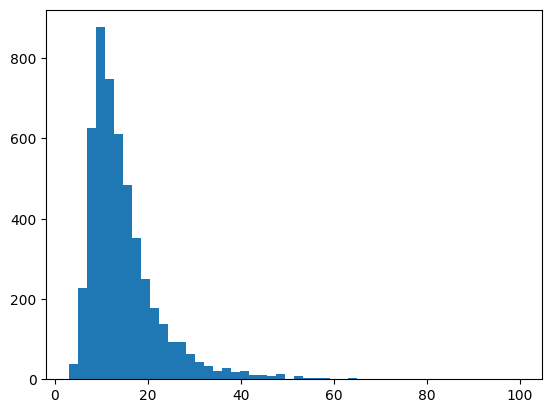

In [20]:
lengths = [len(line["en_ids"]) for line in train_dataset]
plt.hist(lengths, bins=50)
plt.show()

In [21]:
class BucketSampler(torch.utils.data.Sampler):
    def __init__(self, data_source, batch_size, sort_key, drop_last=False, shuffle_batches=True):
        """
        Args:
            data_source: Dataset (обычно список словарей)
            batch_size: Размер батча
            sort_key: Функция, получающая индекс, возвращающая значение для сортировки (например, lambda idx: data_source[idx]['src_len'])
            drop_last: Отбрасывать неполные батчи?
            shuffle_batches: Перемешивать ли порядок батчей (но не сами индексы внутри батча)
        """
        self.data_source = data_source
        self.batch_size = batch_size
        self.sort_key = sort_key
        self.drop_last = drop_last
        self.shuffle_batches = shuffle_batches

        # сортируем их по длине
        self.indices = list(range(len(self.data_source)))
        self.indices.sort(key=self.sort_key)

        self.batches = []
        for i in range(0, len(self.indices), self.batch_size):
            batch_indices = self.indices[i:i + self.batch_size]
            if not self.drop_last or len(batch_indices) == self.batch_size:
                self.batches.append(batch_indices)

        if self.shuffle_batches:
            random.shuffle(self.batches)

    def __iter__(self):
        for batch in self.batches:
            random.shuffle(batch)
            yield batch

    def __len__(self):
        return len(self.batches)

In [22]:
def collate_fn(batch):
    en_ids = [line["en_ids"] for line in batch]
    zt_ids = [line["zt_ids"] for line in batch]
    en_ids = nn.utils.rnn.pad_sequence(en_ids, padding_value=pad_index)
    zt_ids = nn.utils.rnn.pad_sequence(zt_ids, padding_value=pad_index)
    batch = {
        "en_ids": en_ids,
        "zt_ids": zt_ids,
    }
    return batch

In [23]:
def get_dataloader(dataset, sampler, batch_size, shuffle=False):
    dataloader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_sampler=sampler,
        # batch_size=batch_size,
        collate_fn=collate_fn,
        # shuffle=shuffle,
        num_workers=0,
        pin_memory=False

    )
    return dataloader

In [24]:
batch_size = 256

train_sort_key = lambda idx: max(len(train_dataset[idx].get('en_ids', [])), len(train_dataset[idx].get('zt_ids', [])))
train_bucket_sampler = BucketSampler(train_dataset, batch_size, train_sort_key, drop_last=False, shuffle_batches=True)
val_sort_key = train_sort_key
val_bucket_sampler = BucketSampler(val_dataset, batch_size, val_sort_key, drop_last=False, shuffle_batches=False)

train_dataloader = get_dataloader(train_dataset, train_bucket_sampler, batch_size, shuffle=True)
val_dataloader = get_dataloader(val_dataset, val_bucket_sampler, batch_size)

In [25]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, enc_hid_dim, dec_hid_dim, dropout) -> None:
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional=True)
        self.fc = nn.Linear(2 * enc_hid_dim, dec_hid_dim) # 2 because bidirectional
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Forward pass для энкодера sequence-to-sequence модели.

        Args:
            x: [seq_len, batch_size] - исходная последовательность токенов

        Returns:
            outputs: [seq_len, batch_size, 2*enc_hid_dim] - все выходы encoder (для механизма внимания)
            final_hidden: [batch_size, dec_hid_dim] - финальное скрытое состояние для инициализации decoder
        """

        # x: [time, batch] - исходная последовательность токенов

        # Эмбеддинги входных токенов
        embeddings = self.dropout(self.embedding(x)) # [time, batch] -> [time, batch, emb_dim]
        # Проход через двунаправленный GRU
        outputs, enc_hidden = self.rnn(embeddings) # [time, batch, emb_dim] -> [time, batch, 2*enc_hid_dim], [2, batch, enc_hid_dim]

        # Объединяем forward и backward последние состояния и проецируем в размерность decoder
        concatenated = torch.cat((enc_hidden[0], enc_hidden[1]), dim=1)  # [batch, enc_hid_dim] + [batch, enc_hid_dim] -> [batch, 2*enc_hid_dim]
        # Проекция в размерность скрытого состояния decoder
        enc_hidden = torch.tanh(self.fc(concatenated)) # [batch, 2*enc_hid_dim] -> [batch, dec_hid_dim]

        # outputs: [time, batch, 2*enc_hid_dim] - все выходы encoder
        # enc_hidden: [batch, dec_hid_dim] - финальное скрытое состояние для encoder
        return outputs, enc_hidden

In [26]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim) -> None:
        super().__init__()
        # Линейный слой для вычисления энергии
        self.att_fc = nn.Linear(2 * enc_hid_dim + dec_hid_dim, dec_hid_dim)
        # Вектор для проецирования энергии в скаляр
        self.v_fc = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, dec_hid, enc_outputs):
        """
        Args:
            dec_hidden: [batch_size, dec_hid_dim] - скрытое состояние декодера
            enc_outputs: [seq_len, batch_size, 2*enc_hid_dim] - выходы энкодера

        Returns:
            attention_weights: [batch_size, seq_len] - веса внимания
        """

        # dec_hid: [batch, dec_dim] - скрытое состояние декодера
        # enc_outputs: [time, batch, 2*enc_dim] - выходы энкодера

        time_size, batch_size, _ = enc_outputs.shape

        # Повторяем скрытое состояние декодера для каждого временного шага
        dec_hidden_repeated = dec_hid.unsqueeze(1).repeat(1, time_size, 1) # [batch, hid] -> [batch, 1, hid] -> [batch, time, hid]
        # Меняем размерность encoder outputs для удобства
        enc_outputs = enc_outputs.permute(1, 0, 2) # [time, batch, 2*enc_hid] -> [batch, time, 2*enc_hid]
        # Конкатенируем encoder outputs и decoder hidden state
        all_hidden = torch.cat([enc_outputs, dec_hidden_repeated], dim=2) # [batch, time, 2*hid_enc + hid_dec]
        # Вычисляем энергию
        energy = torch.tanh(self.att_fc(all_hidden)) # [batch, time, 2*enc_dim + dec_dim] -> [batch, time, dec_dim]
        # Проектируем энергию в скаляр и убираем последнее измерение
        attention = self.v_fc(energy).squeeze(2) # [batch, time, dec_dim] -> [batch, time, 1] -> [batch, time]

        # Применяем softmax для получения весов внимания
        return torch.softmax(attention, dim=1) # [batch, time] (softmax по временным шагам)

In [27]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention) -> None:
        super().__init__()

        self.vocab_size = vocab_size
        self.attention = attention

        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.rnn = nn.GRU(2 * enc_hid_dim + emb_dim, dec_hid_dim)
        self.fc = nn.Linear(2 * enc_hid_dim + dec_hid_dim + emb_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, dec_hidden, enc_outputs):
        """
        Args:
            x: [batch_size] - входной токен (индекс)
            dec_hidden: [batch_size, dec_hid_dim] - скрытое состояние декодера
            enc_outputs: [seq_len, batch_size, 2*enc_hid_dim] - выходы энкодера

        Returns:
            prediction: [batch_size, vocab_size] - логиты для следующего токена
            dec_hidden: [batch_size, dec_hid_dim] - новое скрытое состояние
            attention_weights: [batch_size, seq_len] - веса внимания
        """

        # x: [batch] - входной токен (индекс)
        # dec_hidden: [batch, dec_dim] - скрытое состояние декодера
        # enc_outputs: [time, batch, 2*enc_dim] - выходы энкодера

        # Embedding входного токена
        x = x.unsqueeze(0) # [batch] -> [1, batch]
        embeddings = self.dropout(self.embedding(x)) # [1, batch] -> [1, batch, emb_dim]
        # Вычисление весов внимания
        attention_vec = self.attention(dec_hidden, enc_outputs).unsqueeze(1) # [1, batch, emb_dim] -> [batch, time] -> [batch, 1, time]
        # Применение внимания к encoder outputs
        enc_outputs = enc_outputs.permute(1, 0, 2) # [time, batch, 2*enc_dim] -> [batch, time, 2*encdim]
        weighted_enc_outputs = torch.bmm(attention_vec, enc_outputs) # [batch, 1, time] x [batch, time, 2*enc_dim] -> [batch, 1, 2*enc_dim]
        weighted_enc_outputs = weighted_enc_outputs.permute(1, 0, 2) # [batch, 1, 2*enc_dim] -> [1, batch, 2*enc_dim]

        # Подготовка входа для RNN
        rnn_input = torch.cat([weighted_enc_outputs, embeddings], dim=2) # [batch, 1, 2*enc_dim + emb_dim]
        # RNN step
        dec_outputs, dec_hidden = self.rnn(rnn_input, dec_hidden.unsqueeze(0)) # [batch, 1, 2*enc_dim + emb_dim] -> [1, batch, dec_dim]

        assert torch.allclose(dec_outputs, dec_hidden, atol=1e-6)

        # Подготовка для финального предсказания
        prediction_input = torch.cat([weighted_enc_outputs, dec_outputs, embeddings], dim=2).squeeze(0) # [batch, 2*enc_dim + dec_dim + emb_dim]
        prediction = self.fc(prediction_input) # [batch, 2*enc_dim + dec_dim + emb_dim] -> [batch, vocab_size]

        # [batch, vocab_size], [batch, dec_dim], [batch, time]
        return prediction, dec_hidden.squeeze(0), attention_vec.squeeze(1)


In [28]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder: Encoder, decoder: Decoder, device) -> None:
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, target, teacher_forcing_ratio):
        # src: [src_time, batch] - исходная последовательность
        # target: [tgt_time, batch] - целевая последовательность

        target_time, batch = target.shape
        target_vocab_size = self.decoder.vocab_size # vocal of target lang

        # Энкодинг входной последовательности
        enc_outputs, dec_hidden = self.encoder(src) # [src_time, batch, 2*enc_hid_dim], [batch, dec_hid_dim]
        # Инициализация выходного тензора
        dec_outputs = torch.zeros(target_time, batch, target_vocab_size).to(self.device) # [trg_time, batch, trg_vocab_size]

        # Первый токен - обычно <BEG> (beginning of sentence)
        input_token = target[0, :] # [batch] - индексы первых токенов в батче
        for t in range(1, target_time):
            # Декодинг одного шага
            prediction, dec_hidden, _ = self.decoder(input_token, dec_hidden, enc_outputs) # [batch, trg_vocab_size], [batch, dec_dim]
            dec_outputs[t] = prediction
            # Teacher forcing: иногда используем ground truth, иногда предсказание модели
            if random.random() < teacher_forcing_ratio:
                input_token = target[t, :] # передаем из оригинальной последовательности
            else:
                # probs = torch.softmax(prediction / 1.0, dim=-1)
                # input_token = torch.multinomial(probs, num_samples=1).squeeze(1)
                input_token = prediction.argmax(1) # передаем результат генерации

        return dec_outputs # [trg_time, batch, trg_vocab_size]



In [29]:
src_vocab_size = zt_tokenizer.get_vocab_size()
trg_vocab_size = en_tokenizer.get_vocab_size()
enc_emb_dim = 64
dec_emb_dim = 64
enc_dim = 64
dec_dim = 64
enc_dropout = 0.5
dec_dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

attention = Attention(enc_dim, dec_dim)
encoder = Encoder(src_vocab_size, enc_emb_dim, enc_dim, dec_dim, enc_dropout)
decoder = Decoder(trg_vocab_size, dec_emb_dim, enc_dim, dec_dim, dec_dropout, attention)
model = Seq2Seq(encoder, decoder, device).to(device)
model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(2000, 64)
    (rnn): GRU(64, 64, bidirectional=True)
    (fc): Linear(in_features=128, out_features=64, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (att_fc): Linear(in_features=192, out_features=64, bias=True)
      (v_fc): Linear(in_features=64, out_features=1, bias=False)
    )
    (embedding): Embedding(2000, 64)
    (rnn): GRU(192, 64)
    (fc): Linear(in_features=256, out_features=2000, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [30]:
def init_weights(model):
    for name, param in model.named_parameters():
        if "weight" in name:
            nn.init.xavier_uniform_(param)
        else:
            nn.init.zeros_(param)
init_weights(model)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Модель имеет {count_parameters(model):,} обучаемых параметров')

Модель имеет 890,128 обучаемых параметров


In [31]:
def train_func(model, dataloader, optimizer, criterion, clip, teacher_enf_rat, device):
    scaler = torch.amp.GradScaler('cuda' if device.type == 'cuda' else 'cpu')

    accumulation_steps = 2  # Накапливать градиенты каждые 2 батча

    model.train()
    epoch_loss = 0
    for i, batch in tqdm(enumerate(dataloader)):
        src = batch["zt_ids"].to(device) # [time, batch]
        trg = batch["en_ids"].to(device) # [time, batch]

        with torch.amp.autocast('cuda' if device.type == 'cuda' else 'cpu'):
            outputs = model(src, trg, teacher_enf_rat)
            trg_vocab_size = outputs.shape[-1]

            outputs = outputs[1:].view(-1, trg_vocab_size)
            trg = trg[1:].view(-1)

            loss = criterion(outputs, trg)

        scaler.scale(loss).backward()
        epoch_loss += loss.item()

        if (i + 1) % accumulation_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            if i % 100 == 0:
                torch.cuda.empty_cache()


    return epoch_loss / len(dataloader)

def eval_func(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for i, batch in tqdm(enumerate(dataloader)):
            src = batch["zt_ids"].to(device) # [time, batch]
            trg = batch["en_ids"].to(device) # [time, batch]

            outputs = model(src, trg, teacher_forcing_ratio=0) # [trg_time, batch, trg_vocab_size]
            trg_vocab_size = outputs.shape[-1]

            outputs = outputs[1:].view(-1, trg_vocab_size) # [(time-1)*batch, trg_vocab_size]
            trg = trg[1:].view(-1) # [(time-1)*batch]

            loss = criterion(outputs, trg)
            total_loss += loss.item()

    return total_loss / len(dataloader)

In [32]:
epochs = 100
clip = 1.0
teacher_enforce_ratio = 0.3

best_valid_loss = float("inf")

optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

train_losses = []
valid_losses = []
for epoch in range(epochs):
    train_loss = train_func(model, train_dataloader, optimizer, criterion, clip, teacher_enforce_ratio, device)
    val_loss = eval_func(model, val_dataloader, criterion, device)
    train_losses.append(train_loss)
    valid_losses.append(val_loss)

    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model.state_dict(), 'zt2en-model.pt')

    print(f"Epoch #{epoch}:")
    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {val_loss:7.3f} | Valid PPL: {np.exp(val_loss):7.3f}")

20it [00:03,  5.10it/s]
2it [00:00,  2.26it/s]


Epoch #0:
	Train Loss:   7.581 | Train PPL: 1960.776
	Valid Loss:   7.553 | Valid PPL: 1907.066


20it [00:03,  6.03it/s]
2it [00:00,  2.31it/s]


Epoch #1:
	Train Loss:   7.405 | Train PPL: 1644.381
	Valid Loss:   7.129 | Valid PPL: 1248.074


20it [00:03,  6.04it/s]
2it [00:00,  2.34it/s]


Epoch #2:
	Train Loss:   6.497 | Train PPL: 662.992
	Valid Loss:   7.031 | Valid PPL: 1131.601


20it [00:03,  6.14it/s]
2it [00:00,  2.38it/s]


Epoch #3:
	Train Loss:   5.860 | Train PPL: 350.632
	Valid Loss:   8.079 | Valid PPL: 3227.120


20it [00:03,  6.12it/s]
2it [00:00,  2.40it/s]


Epoch #4:
	Train Loss:   5.697 | Train PPL: 298.012
	Valid Loss:   6.993 | Valid PPL: 1089.449


20it [00:03,  6.13it/s]
2it [00:00,  2.36it/s]


Epoch #5:
	Train Loss:   5.649 | Train PPL: 283.934
	Valid Loss:   6.894 | Valid PPL: 986.729


20it [00:03,  6.11it/s]
2it [00:00,  2.35it/s]


Epoch #6:
	Train Loss:   5.610 | Train PPL: 273.262
	Valid Loss:   7.002 | Valid PPL: 1098.881


20it [00:03,  6.04it/s]
2it [00:00,  2.39it/s]


Epoch #7:
	Train Loss:   5.578 | Train PPL: 264.440
	Valid Loss:   6.914 | Valid PPL: 1005.786


20it [00:03,  6.09it/s]
2it [00:00,  2.34it/s]


Epoch #8:
	Train Loss:   5.551 | Train PPL: 257.546
	Valid Loss:   6.872 | Valid PPL: 965.188


20it [00:03,  6.04it/s]
2it [00:00,  2.27it/s]


Epoch #9:
	Train Loss:   5.526 | Train PPL: 251.027
	Valid Loss:   6.853 | Valid PPL: 946.591


20it [00:03,  5.74it/s]
2it [00:00,  2.19it/s]


Epoch #10:
	Train Loss:   5.498 | Train PPL: 244.293
	Valid Loss:   6.829 | Valid PPL: 924.360


20it [00:03,  5.85it/s]
2it [00:00,  2.33it/s]


Epoch #11:
	Train Loss:   5.474 | Train PPL: 238.324
	Valid Loss:   6.813 | Valid PPL: 909.340


20it [00:03,  6.03it/s]
2it [00:00,  2.34it/s]


Epoch #12:
	Train Loss:   5.450 | Train PPL: 232.732
	Valid Loss:   6.794 | Valid PPL: 892.684


20it [00:03,  5.91it/s]
2it [00:00,  2.33it/s]


Epoch #13:
	Train Loss:   5.429 | Train PPL: 227.959
	Valid Loss:   6.782 | Valid PPL: 881.947


20it [00:03,  6.01it/s]
2it [00:00,  2.33it/s]


Epoch #14:
	Train Loss:   5.407 | Train PPL: 223.003
	Valid Loss:   6.768 | Valid PPL: 869.753


20it [00:03,  5.98it/s]
2it [00:00,  2.33it/s]


Epoch #15:
	Train Loss:   5.396 | Train PPL: 220.426
	Valid Loss:   6.743 | Valid PPL: 848.288


20it [00:03,  6.01it/s]
2it [00:00,  2.34it/s]


Epoch #16:
	Train Loss:   5.386 | Train PPL: 218.360
	Valid Loss:   6.705 | Valid PPL: 816.575


20it [00:03,  5.97it/s]
2it [00:00,  2.31it/s]


Epoch #17:
	Train Loss:   5.368 | Train PPL: 214.402
	Valid Loss:   6.677 | Valid PPL: 794.232


20it [00:03,  5.99it/s]
2it [00:00,  2.32it/s]


Epoch #18:
	Train Loss:   5.339 | Train PPL: 208.280
	Valid Loss:   6.644 | Valid PPL: 768.330


20it [00:03,  5.94it/s]
2it [00:00,  2.47it/s]


Epoch #19:
	Train Loss:   5.308 | Train PPL: 201.974
	Valid Loss:   6.611 | Valid PPL: 743.020


20it [00:03,  6.30it/s]
2it [00:00,  2.47it/s]


Epoch #20:
	Train Loss:   5.282 | Train PPL: 196.859
	Valid Loss:   6.579 | Valid PPL: 719.497


20it [00:03,  6.35it/s]
2it [00:00,  2.37it/s]


Epoch #21:
	Train Loss:   5.272 | Train PPL: 194.863
	Valid Loss:   6.552 | Valid PPL: 700.507


20it [00:03,  6.30it/s]
2it [00:00,  2.50it/s]


Epoch #22:
	Train Loss:   5.261 | Train PPL: 192.614
	Valid Loss:   6.535 | Valid PPL: 688.982


20it [00:03,  5.53it/s]
2it [00:00,  2.45it/s]


Epoch #23:
	Train Loss:   5.225 | Train PPL: 185.922
	Valid Loss:   6.519 | Valid PPL: 677.615


20it [00:03,  6.26it/s]
2it [00:00,  2.44it/s]


Epoch #24:
	Train Loss:   5.206 | Train PPL: 182.376
	Valid Loss:   6.512 | Valid PPL: 672.998


20it [00:03,  6.34it/s]
2it [00:00,  2.48it/s]


Epoch #25:
	Train Loss:   5.201 | Train PPL: 181.434
	Valid Loss:   6.514 | Valid PPL: 674.439


20it [00:03,  6.29it/s]
2it [00:00,  2.48it/s]


Epoch #26:
	Train Loss:   5.165 | Train PPL: 174.972
	Valid Loss:   6.500 | Valid PPL: 664.857


20it [00:03,  5.88it/s]
2it [00:00,  2.14it/s]


Epoch #27:
	Train Loss:   5.153 | Train PPL: 173.008
	Valid Loss:   6.495 | Valid PPL: 661.798


20it [00:03,  5.72it/s]
2it [00:00,  2.14it/s]


Epoch #28:
	Train Loss:   5.158 | Train PPL: 173.739
	Valid Loss:   6.517 | Valid PPL: 676.727


20it [00:03,  5.79it/s]
2it [00:00,  2.32it/s]


Epoch #29:
	Train Loss:   5.165 | Train PPL: 175.097
	Valid Loss:   6.473 | Valid PPL: 647.545


20it [00:03,  6.01it/s]
2it [00:00,  2.31it/s]


Epoch #30:
	Train Loss:   5.170 | Train PPL: 175.905
	Valid Loss:   6.464 | Valid PPL: 641.838


20it [00:03,  6.00it/s]
2it [00:00,  2.35it/s]


Epoch #31:
	Train Loss:   5.160 | Train PPL: 174.177
	Valid Loss:   6.483 | Valid PPL: 654.160


20it [00:03,  5.93it/s]
2it [00:00,  2.33it/s]


Epoch #32:
	Train Loss:   5.148 | Train PPL: 172.059
	Valid Loss:   6.465 | Valid PPL: 642.442


20it [00:03,  5.99it/s]
2it [00:00,  2.32it/s]


Epoch #33:
	Train Loss:   5.193 | Train PPL: 180.048
	Valid Loss:   6.493 | Valid PPL: 660.455


20it [00:03,  5.92it/s]
2it [00:00,  2.23it/s]


Epoch #34:
	Train Loss:   5.179 | Train PPL: 177.521
	Valid Loss:   6.472 | Valid PPL: 646.499


20it [00:03,  5.71it/s]
2it [00:00,  2.33it/s]


Epoch #35:
	Train Loss:   5.148 | Train PPL: 172.096
	Valid Loss:   6.481 | Valid PPL: 652.363


20it [00:03,  5.64it/s]
2it [00:00,  2.12it/s]


Epoch #36:
	Train Loss:   5.134 | Train PPL: 169.625
	Valid Loss:   6.482 | Valid PPL: 653.037


20it [00:03,  5.95it/s]
2it [00:00,  2.36it/s]


Epoch #37:
	Train Loss:   5.160 | Train PPL: 174.108
	Valid Loss:   6.467 | Valid PPL: 643.398


20it [00:03,  6.05it/s]
2it [00:00,  2.36it/s]


Epoch #38:
	Train Loss:   5.135 | Train PPL: 169.931
	Valid Loss:   6.484 | Valid PPL: 654.440


20it [00:03,  6.00it/s]
2it [00:00,  2.34it/s]


Epoch #39:
	Train Loss:   5.119 | Train PPL: 167.208
	Valid Loss:   6.480 | Valid PPL: 652.211


20it [00:03,  5.96it/s]
2it [00:00,  2.33it/s]


Epoch #40:
	Train Loss:   5.119 | Train PPL: 167.105
	Valid Loss:   6.479 | Valid PPL: 651.016


20it [00:03,  5.98it/s]
2it [00:00,  2.33it/s]


Epoch #41:
	Train Loss:   5.113 | Train PPL: 166.245
	Valid Loss:   6.457 | Valid PPL: 637.416


20it [00:03,  5.93it/s]
2it [00:00,  2.33it/s]


Epoch #42:
	Train Loss:   5.101 | Train PPL: 164.250
	Valid Loss:   6.456 | Valid PPL: 636.225


20it [00:03,  5.96it/s]
2it [00:00,  2.33it/s]


Epoch #43:
	Train Loss:   5.080 | Train PPL: 160.742
	Valid Loss:   6.449 | Valid PPL: 631.992


20it [00:03,  5.99it/s]
2it [00:00,  2.39it/s]


Epoch #44:
	Train Loss:   5.088 | Train PPL: 162.077
	Valid Loss:   6.467 | Valid PPL: 643.426


20it [00:03,  5.98it/s]
2it [00:00,  2.32it/s]


Epoch #45:
	Train Loss:   5.072 | Train PPL: 159.415
	Valid Loss:   6.474 | Valid PPL: 648.140


20it [00:03,  5.96it/s]
2it [00:00,  2.33it/s]


Epoch #46:
	Train Loss:   5.089 | Train PPL: 162.218
	Valid Loss:   6.491 | Valid PPL: 659.164


20it [00:03,  5.94it/s]
2it [00:00,  2.34it/s]


Epoch #47:
	Train Loss:   5.083 | Train PPL: 161.178
	Valid Loss:   6.460 | Valid PPL: 638.836


20it [00:03,  5.99it/s]
2it [00:00,  2.34it/s]


Epoch #48:
	Train Loss:   5.066 | Train PPL: 158.576
	Valid Loss:   6.459 | Valid PPL: 638.316


20it [00:03,  5.91it/s]
2it [00:00,  2.24it/s]


Epoch #49:
	Train Loss:   5.073 | Train PPL: 159.595
	Valid Loss:   6.466 | Valid PPL: 642.794


20it [00:03,  5.83it/s]
2it [00:00,  2.33it/s]


Epoch #50:
	Train Loss:   5.057 | Train PPL: 157.140
	Valid Loss:   6.459 | Valid PPL: 638.604


20it [00:03,  5.96it/s]
2it [00:00,  2.34it/s]


Epoch #51:
	Train Loss:   5.059 | Train PPL: 157.483
	Valid Loss:   6.480 | Valid PPL: 652.262


20it [00:03,  5.98it/s]
2it [00:00,  2.33it/s]


Epoch #52:
	Train Loss:   5.056 | Train PPL: 156.987
	Valid Loss:   6.458 | Valid PPL: 637.635


20it [00:03,  5.91it/s]
2it [00:00,  2.26it/s]


Epoch #53:
	Train Loss:   5.078 | Train PPL: 160.436
	Valid Loss:   6.460 | Valid PPL: 639.349


20it [00:03,  5.77it/s]
2it [00:00,  2.30it/s]


Epoch #54:
	Train Loss:   5.072 | Train PPL: 159.547
	Valid Loss:   6.459 | Valid PPL: 638.536


20it [00:03,  5.91it/s]
2it [00:00,  2.24it/s]


Epoch #55:
	Train Loss:   5.102 | Train PPL: 164.322
	Valid Loss:   6.442 | Valid PPL: 627.938


20it [00:03,  5.69it/s]
2it [00:00,  2.31it/s]


Epoch #56:
	Train Loss:   5.105 | Train PPL: 164.763
	Valid Loss:   6.447 | Valid PPL: 630.862


20it [00:03,  5.79it/s]
2it [00:00,  2.23it/s]


Epoch #57:
	Train Loss:   5.079 | Train PPL: 160.646
	Valid Loss:   6.451 | Valid PPL: 633.412


20it [00:03,  5.59it/s]
2it [00:00,  2.11it/s]


Epoch #58:
	Train Loss:   5.049 | Train PPL: 155.895
	Valid Loss:   6.487 | Valid PPL: 656.586


20it [00:03,  5.89it/s]
2it [00:00,  2.21it/s]


Epoch #59:
	Train Loss:   5.047 | Train PPL: 155.519
	Valid Loss:   6.450 | Valid PPL: 632.628


20it [00:03,  5.49it/s]
2it [00:00,  2.16it/s]


Epoch #60:
	Train Loss:   5.036 | Train PPL: 153.920
	Valid Loss:   6.469 | Valid PPL: 644.555


20it [00:03,  5.79it/s]
2it [00:00,  2.25it/s]


Epoch #61:
	Train Loss:   5.032 | Train PPL: 153.191
	Valid Loss:   6.448 | Valid PPL: 631.529


20it [00:03,  5.95it/s]
2it [00:00,  2.30it/s]


Epoch #62:
	Train Loss:   5.046 | Train PPL: 155.400
	Valid Loss:   6.437 | Valid PPL: 624.309


20it [00:03,  5.95it/s]
2it [00:00,  2.29it/s]


Epoch #63:
	Train Loss:   5.033 | Train PPL: 153.341
	Valid Loss:   6.435 | Valid PPL: 623.203


20it [00:03,  5.91it/s]
2it [00:00,  2.31it/s]


Epoch #64:
	Train Loss:   5.046 | Train PPL: 155.395
	Valid Loss:   6.445 | Valid PPL: 629.507


20it [00:03,  5.87it/s]
2it [00:00,  2.29it/s]


Epoch #65:
	Train Loss:   5.024 | Train PPL: 151.984
	Valid Loss:   6.448 | Valid PPL: 631.156


20it [00:03,  5.95it/s]
2it [00:00,  2.29it/s]


Epoch #66:
	Train Loss:   5.022 | Train PPL: 151.778
	Valid Loss:   6.480 | Valid PPL: 651.656


20it [00:03,  5.86it/s]
2it [00:00,  2.30it/s]


Epoch #67:
	Train Loss:   5.056 | Train PPL: 156.905
	Valid Loss:   6.469 | Valid PPL: 644.848


20it [00:03,  5.94it/s]
2it [00:00,  2.34it/s]


Epoch #68:
	Train Loss:   5.058 | Train PPL: 157.303
	Valid Loss:   6.494 | Valid PPL: 660.936


20it [00:03,  5.97it/s]
2it [00:00,  2.34it/s]


Epoch #69:
	Train Loss:   5.054 | Train PPL: 156.689
	Valid Loss:   6.445 | Valid PPL: 629.546


20it [00:03,  5.97it/s]
2it [00:00,  2.30it/s]


Epoch #70:
	Train Loss:   5.065 | Train PPL: 158.366
	Valid Loss:   6.453 | Valid PPL: 634.864


20it [00:03,  5.97it/s]
2it [00:00,  2.27it/s]


Epoch #71:
	Train Loss:   5.053 | Train PPL: 156.560
	Valid Loss:   6.477 | Valid PPL: 649.873


20it [00:03,  5.92it/s]
2it [00:00,  2.33it/s]


Epoch #72:
	Train Loss:   5.030 | Train PPL: 152.875
	Valid Loss:   6.468 | Valid PPL: 644.225


20it [00:03,  5.94it/s]
2it [00:00,  2.34it/s]


Epoch #73:
	Train Loss:   5.031 | Train PPL: 153.023
	Valid Loss:   6.468 | Valid PPL: 644.007


20it [00:03,  5.93it/s]
2it [00:00,  2.32it/s]


Epoch #74:
	Train Loss:   5.048 | Train PPL: 155.691
	Valid Loss:   6.445 | Valid PPL: 629.564


20it [00:03,  5.95it/s]
2it [00:00,  2.30it/s]


Epoch #75:
	Train Loss:   5.056 | Train PPL: 157.013
	Valid Loss:   6.460 | Valid PPL: 638.805


20it [00:03,  5.96it/s]
2it [00:00,  2.33it/s]


Epoch #76:
	Train Loss:   5.047 | Train PPL: 155.513
	Valid Loss:   6.458 | Valid PPL: 637.956


20it [00:03,  5.96it/s]
2it [00:00,  2.34it/s]


Epoch #77:
	Train Loss:   5.024 | Train PPL: 151.954
	Valid Loss:   6.460 | Valid PPL: 639.197


20it [00:03,  5.98it/s]
2it [00:00,  2.32it/s]


Epoch #78:
	Train Loss:   5.012 | Train PPL: 150.255
	Valid Loss:   6.439 | Valid PPL: 625.803


20it [00:03,  5.96it/s]
2it [00:00,  2.26it/s]


Epoch #79:
	Train Loss:   5.019 | Train PPL: 151.233
	Valid Loss:   6.477 | Valid PPL: 650.308


20it [00:03,  5.94it/s]
2it [00:00,  2.30it/s]


Epoch #80:
	Train Loss:   5.012 | Train PPL: 150.150
	Valid Loss:   6.441 | Valid PPL: 626.762


20it [00:03,  5.92it/s]
2it [00:00,  2.34it/s]


Epoch #81:
	Train Loss:   5.019 | Train PPL: 151.224
	Valid Loss:   6.490 | Valid PPL: 658.397


20it [00:03,  5.92it/s]
2it [00:00,  2.29it/s]


Epoch #82:
	Train Loss:   5.051 | Train PPL: 156.101
	Valid Loss:   6.467 | Valid PPL: 643.777


20it [00:03,  5.87it/s]
2it [00:00,  2.28it/s]


Epoch #83:
	Train Loss:   5.061 | Train PPL: 157.824
	Valid Loss:   6.470 | Valid PPL: 645.518


20it [00:03,  5.88it/s]
2it [00:00,  2.26it/s]


Epoch #84:
	Train Loss:   5.036 | Train PPL: 153.922
	Valid Loss:   6.454 | Valid PPL: 635.376


20it [00:03,  5.91it/s]
2it [00:00,  2.35it/s]


Epoch #85:
	Train Loss:   5.036 | Train PPL: 153.848
	Valid Loss:   6.465 | Valid PPL: 642.434


20it [00:03,  5.98it/s]
2it [00:00,  2.32it/s]


Epoch #86:
	Train Loss:   5.007 | Train PPL: 149.387
	Valid Loss:   6.454 | Valid PPL: 635.286


20it [00:03,  5.97it/s]
2it [00:00,  2.30it/s]


Epoch #87:
	Train Loss:   4.997 | Train PPL: 147.989
	Valid Loss:   6.466 | Valid PPL: 643.177


20it [00:03,  5.99it/s]
2it [00:00,  2.31it/s]


Epoch #88:
	Train Loss:   5.003 | Train PPL: 148.804
	Valid Loss:   6.513 | Valid PPL: 674.009


20it [00:03,  5.81it/s]
2it [00:00,  2.32it/s]


Epoch #89:
	Train Loss:   5.021 | Train PPL: 151.576
	Valid Loss:   6.445 | Valid PPL: 629.539


20it [00:03,  5.87it/s]
2it [00:00,  2.28it/s]


Epoch #90:
	Train Loss:   5.070 | Train PPL: 159.146
	Valid Loss:   6.443 | Valid PPL: 627.997


20it [00:03,  5.73it/s]
2it [00:00,  2.14it/s]


Epoch #91:
	Train Loss:   5.057 | Train PPL: 157.160
	Valid Loss:   6.438 | Valid PPL: 625.318


20it [00:03,  5.63it/s]
2it [00:00,  2.30it/s]


Epoch #92:
	Train Loss:   5.031 | Train PPL: 153.021
	Valid Loss:   6.457 | Valid PPL: 637.281


20it [00:03,  5.81it/s]
2it [00:00,  2.32it/s]


Epoch #93:
	Train Loss:   5.031 | Train PPL: 153.057
	Valid Loss:   6.455 | Valid PPL: 635.609


20it [00:03,  5.80it/s]
2it [00:00,  2.16it/s]


Epoch #94:
	Train Loss:   5.042 | Train PPL: 154.728
	Valid Loss:   6.456 | Valid PPL: 636.743


20it [00:03,  5.67it/s]
2it [00:00,  2.15it/s]


Epoch #95:
	Train Loss:   5.033 | Train PPL: 153.469
	Valid Loss:   6.462 | Valid PPL: 640.401


20it [00:03,  5.57it/s]
2it [00:00,  2.19it/s]


Epoch #96:
	Train Loss:   5.068 | Train PPL: 158.866
	Valid Loss:   6.422 | Valid PPL: 615.205


20it [00:03,  5.66it/s]
2it [00:00,  2.30it/s]


Epoch #97:
	Train Loss:   5.055 | Train PPL: 156.875
	Valid Loss:   6.505 | Valid PPL: 668.687


20it [00:03,  5.94it/s]
2it [00:00,  2.29it/s]


Epoch #98:
	Train Loss:   5.028 | Train PPL: 152.636
	Valid Loss:   6.437 | Valid PPL: 624.532


20it [00:03,  5.89it/s]
2it [00:00,  2.16it/s]

Epoch #99:
	Train Loss:   5.029 | Train PPL: 152.807
	Valid Loss:   6.447 | Valid PPL: 630.855


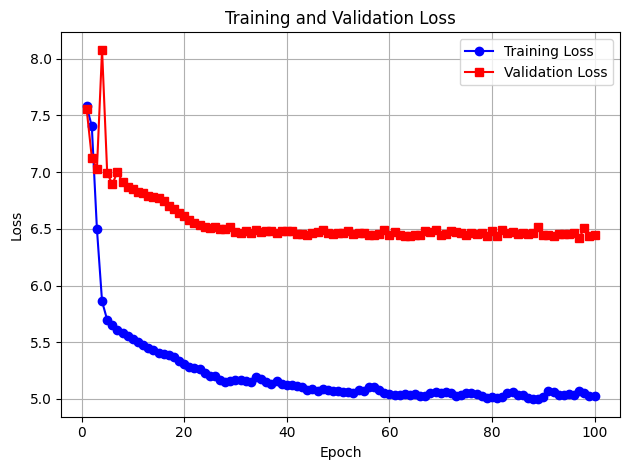

In [33]:
plt.plot(range(1, epochs+1), train_losses, 'b-', marker='o', label='Training Loss')
plt.plot(range(1, epochs+1), valid_losses, 'r-', marker='s', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [34]:
def translate_sentence(model, sentence, en_tokenizer, zt_tokenizer, device, beg_index, end_index, max_len=50):
    model.eval()

    dataset = {"src": sentence}
    tokenize([dataset], en_tokenizer, zt_tokenizer)
    src_ids = dataset["zt_ids"].unsqueeze(1).to(device)

    with torch.no_grad():
        enc_outputs, hidden = model.encoder(src_ids)
        trg_ids = [beg_index]

        input_token = torch.tensor([beg_index]).to(device)
        attentions = torch.zeros(max_len, 1, len(src_ids))
        for t in range(1, max_len):
            output, hidden, attention = model.decoder(input_token, hidden, enc_outputs)
            attentions[t] = attention

            probs = torch.softmax(output / 1.0, dim=-1)
            prediction_index = torch.multinomial(probs, num_samples=1).squeeze(1)
            # prediction_index = output.argmax(1)

            trg_ids.append(prediction_index.item())
            input_token = prediction_index

            if prediction_index == end_index:
                break

    trg_tokens = [en_tokenizer.id_to_token(i) for i in trg_ids]
    return dataset["zt_tokens"], trg_tokens, attentions[:len(trg_tokens)-1]



In [35]:
model.load_state_dict(torch.load("zt2en-model.pt"))

for line in test_dataset:
    _, tokens, _ = translate_sentence(model, line["src"], en_tokenizer, zt_tokenizer, device, beg_index, end_index)
    ids = [en_tokenizer.token_to_id(token) for token in tokens]
    sentence = en_tokenizer.decode(ids)
    # line["dst"] = sentence
    print(line["src"], sentence, sep="\n")
    break


◲▦◠▦◬▦■ ◉◗▢◕◗ ◍◗▱◎ ▽◠▽▪▦◠ ◕▴◉◗▦▼▴ ◀◗◓◉◧▨ ◎▴◞◠▸ ◠▱◈▪▨ ◚◪ ◀◨ ◎◪◞◠▸▱◠◓◬▦ ◀◠▢▪▱◠◓▪ ▻◪▨ ◈◂◞▫◉◠ ◈▴◐◫▱◈◗▵
- and gone b inlly yourorown down your side...o, will blood sa and cross the troubleel alone on don.


In [36]:
def plot_attention(sentence, translation, attention):
    fig, ax = plt.subplots(figsize=(10, 10))
    attention = attention.squeeze(1).numpy()
    cax = ax.matshow(attention, cmap="bone")
    ax.set_xticks(ticks=np.arange(len(sentence)), labels=sentence, rotation=90, size=15)
    translation = translation[1:]
    ax.set_yticks(ticks=np.arange(len(translation)), labels=translation, size=15)
    plt.show()
    plt.close()

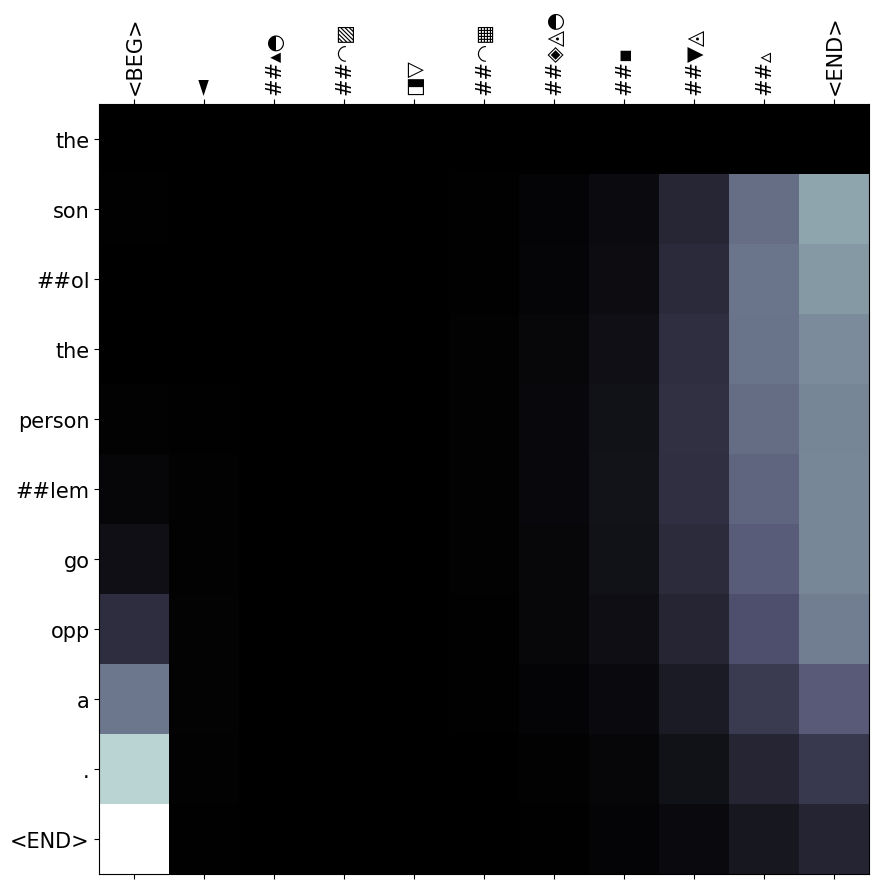

In [37]:
zt = "◄▴◓◠▨ ◨▽◠▦◈◬◓▪▼◬▵"

zt_tokens, en_tokens, attentions = translate_sentence(model, zt, en_tokenizer, zt_tokenizer, device, beg_index, end_index)
plot_attention(zt_tokens, en_tokens, attentions)

In [38]:
!pip install bleuscore

In [39]:
import bleuscore

translations = [
    translate_sentence(model, example["src"], en_tokenizer, zt_tokenizer, device, beg_index, end_index)[1]
    for example in tqdm(val_dataset)
]


predictions = ["".join(translation[1:-1]) for translation in translations]
references = [[example["dst"]] for example in val_dataset]

results = bleuscore.compute(predictions=predictions, references=references)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:37<00:00, 13.51it/s]


In [40]:
results

{'bleu': 0.0,
 'precisions': [0.04093231528790401, 0.00017731544417518767, 0.0, 0.0],
 'brevity_penalty': 1.0,
 'length_ratio': 1.3648045130455222,
 'translation_length': 17419,
 'reference_length': 12763}